<a href="https://colab.research.google.com/github/archie10/archie10.github.io/blob/main/SportsImageClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import os
import time
import copy
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import huggingface_hub as huggingface
from transformers import AutoImageProcessor
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import wandb
import kagglehub

In [7]:
wandb.login()

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 2


wandb: You chose 'Use an existing W&B account'
wandb: Logging into https://api.wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: Find your API key here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: ak205961 (ak205961-dalhousie-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [8]:


# Download latest version
path = kagglehub.dataset_download("gpiosenka/sports-classification")

print("Path to dataset files:", path)

100%|██████████| 424M/424M [00:10<00:00, 40.6MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/gpiosenka/sports-classification/versions/9


#Transforms
Create transforms for train and val data for Augmentation and Normalizing images

In [9]:
data_transforms = {

                   'train' : transforms.Compose([transforms.RandomResizedCrop(224),transforms.RandomHorizontalFlip(),transforms.ToTensor(),transforms.Normalize([0.490, 0.449, 0.411], [0.231, 0.221, 0.230])]) ,

                   'valid' : transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224), transforms.ToTensor(), transforms.Normalize([0.490, 0.449, 0.411],[0.231, 0.221, 0.230])])
}

In [6]:
img_data = { k: datasets.ImageFolder(os.path.join(path,k), data_transforms[k]) for k in ['train', 'valid']}

# Visualize images
Visualize 5 random images with their corresponding labels from the 'train' split of the loaded image dataset, ensuring correct denormalization.

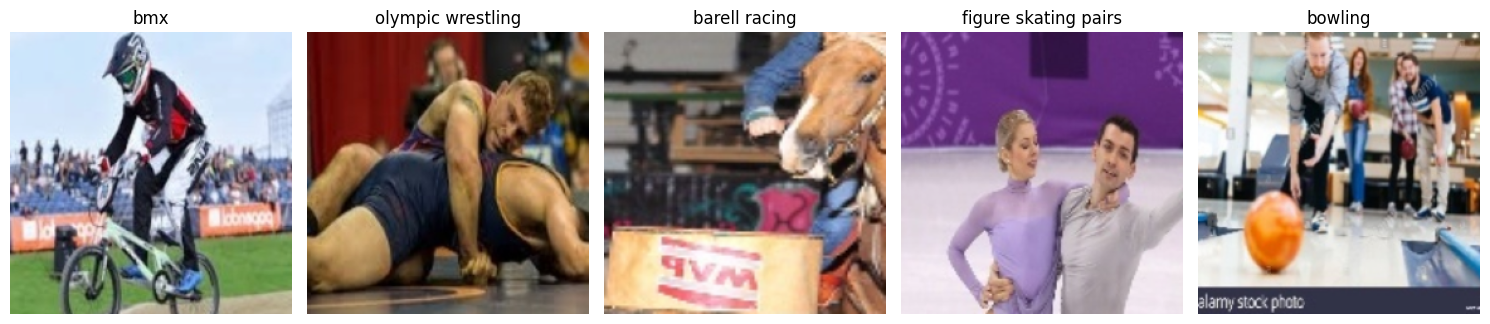

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Get class names from the dataset
idx_to_class = {v: k for k, v in img_data['train'].class_to_idx.items()}

# Select 5 random indices
num_samples_to_show = 5
random_indices = np.random.choice(len(img_data['train']), num_samples_to_show, replace=False)

plt.figure(figsize=(15, 5))
for i, idx in enumerate(random_indices):
    image, label_idx = img_data['train'][idx]

    # Denormalize image for display
    # Mean and Std from the transform definition
    mean = np.array([0.490, 0.449, 0.411])
    std = np.array([0.231, 0.221, 0.230])
    image_np = image.numpy().transpose((1, 2, 0)) # Convert from (C, H, W) to (H, W, C)
    image_np = std * image_np + mean # Denormalize
    image_np = np.clip(image_np, 0, 1) # Clip to [0,1]

    label_name = idx_to_class[label_idx]

    plt.subplot(1, num_samples_to_show, i + 1)
    plt.imshow(image_np)
    plt.title(label_name)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [8]:
wandb.init(project="sports_image_classification", config={
    "learning_rate": 0.001,
    "epochs": 10,
    "batch_size": 32,
    "image_size": 224,
    "num_classes": len(img_data['train'].classes),
    "model_name": "resnet18",
    "optimizer": "Adam",
    "device": "cuda" if torch.cuda.is_available() else "cpu"
})
config = wandb.config

In [12]:
data_loaders = {k: torch.utils.data.DataLoader(img_data[k], batch_size = config.batch_size, shuffle = True) for k in ['train', 'valid']}
data_sizes = {k: len(img_data[k]) for k in ['train', 'valid']}


In [10]:
def finetune_model(model, criterion, optimizer, num_epochs=25):
    since = time.time()

    # Initialize variables for tracking the best model
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # Define the device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in data_loaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / data_sizes[phase]
            epoch_acc = running_corrects.double() / data_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            wandb.log({f'{phase}_loss': epoch_loss, f'{phase}_accuracy': epoch_acc}, step=epoch)

            # deep copy the model if it's the best validation accuracy
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

Fine Tuning ResNet18

In [12]:
model_finetune = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 194MB/s]


In [13]:
print(model_finetune)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [14]:
print(model_finetune.fc)

Linear(in_features=512, out_features=1000, bias=True)


In [15]:
model_finetune.fc = nn.Linear(model_finetune.fc.in_features, config.num_classes)


In [16]:
model_finetune

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [17]:
loss_func = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_finetune.parameters(), lr=0.0001, momentum=0.9)
model_finetune = finetune_model(model_finetune, loss_func, optimizer_ft, num_epochs=config.epochs)


Epoch 0/9
----------
train Loss: 4.5608 Acc: 0.0329
valid Loss: 4.2856 Acc: 0.0900

Epoch 1/9
----------
train Loss: 4.1624 Acc: 0.1262
valid Loss: 3.8139 Acc: 0.2400

Epoch 2/9
----------
train Loss: 3.7804 Acc: 0.2427
valid Loss: 3.3093 Acc: 0.3420

Epoch 3/9
----------
train Loss: 3.3981 Acc: 0.3412
valid Loss: 2.8425 Acc: 0.4860

Epoch 4/9
----------
train Loss: 3.0515 Acc: 0.4185
valid Loss: 2.4453 Acc: 0.5420

Epoch 5/9
----------
train Loss: 2.7523 Acc: 0.4788
valid Loss: 2.1413 Acc: 0.6180

Epoch 6/9
----------
train Loss: 2.5060 Acc: 0.5276
valid Loss: 1.8770 Acc: 0.6640

Epoch 7/9
----------
train Loss: 2.2918 Acc: 0.5643
valid Loss: 1.6603 Acc: 0.7100

Epoch 8/9
----------
train Loss: 2.1255 Acc: 0.5935
valid Loss: 1.4848 Acc: 0.7280

Epoch 9/9
----------
train Loss: 1.9750 Acc: 0.6184
valid Loss: 1.3521 Acc: 0.7500

Training complete in 6m 42s
Best val Acc: 0.7500


In [18]:
wandb.finish()

train_accuracy,▁▂▄▅▆▆▇▇██
train_loss,█▇▆▅▄▃▂▂▁▁
valid_accuracy,▁▃▄▅▆▇▇███
valid_loss,█▇▆▅▄▃▂▂▁▁
train_accuracy,0.61844
train_loss,1.97497
valid_accuracy,0.75
valid_loss,1.35212


In [19]:
wandb.init(project="sports_image_classification", config={
    "learning_rate": 0.001,
    "epochs": 10,
    "batch_size": 32,
    "image_size": 224,
    "num_classes": len(img_data['train'].classes),
    "model_name": "resnet34",
    "optimizer": "Adam",
    "device": "cuda" if torch.cuda.is_available() else "cpu"
})
config = wandb.config

## Load new pre-trained model

###Resnet34


In [20]:
model_finetune = models.resnet34(weights=models.ResNet34_Weights.DEFAULT)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


100%|██████████| 83.3M/83.3M [00:00<00:00, 150MB/s]


In [21]:
print(model_finetune)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [22]:
print(model_finetune.fc)

Linear(in_features=512, out_features=1000, bias=True)


In [24]:
model_finetune.fc = nn.Linear(model_finetune.fc.in_features, config.num_classes)

In [25]:
print(model_finetune)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [26]:
loss_func = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_finetune.parameters(), lr=config.learning_rate, momentum=0.9)

In [27]:
model_finetune = finetune_model(model_finetune, loss_func, optimizer_ft, num_epochs=config.epochs)

Epoch 0/9
----------
train Loss: 2.8738 Acc: 0.3970
valid Loss: 1.0524 Acc: 0.7840

Epoch 1/9
----------
train Loss: 1.2814 Acc: 0.7077
valid Loss: 0.4874 Acc: 0.9020

Epoch 2/9
----------
train Loss: 0.8963 Acc: 0.7865
valid Loss: 0.3110 Acc: 0.9300

Epoch 3/9
----------
train Loss: 0.7226 Acc: 0.8260
valid Loss: 0.2508 Acc: 0.9420

Epoch 4/9
----------
train Loss: 0.6204 Acc: 0.8473
valid Loss: 0.2147 Acc: 0.9460

Epoch 5/9
----------
train Loss: 0.5494 Acc: 0.8647
valid Loss: 0.1931 Acc: 0.9460

Epoch 6/9
----------
train Loss: 0.5033 Acc: 0.8741
valid Loss: 0.1710 Acc: 0.9580

Epoch 7/9
----------
train Loss: 0.4649 Acc: 0.8815
valid Loss: 0.1606 Acc: 0.9460

Epoch 8/9
----------
train Loss: 0.4225 Acc: 0.8907
valid Loss: 0.1498 Acc: 0.9620

Epoch 9/9
----------
train Loss: 0.4138 Acc: 0.8934
valid Loss: 0.1372 Acc: 0.9680

Training complete in 7m 22s
Best val Acc: 0.9680


In [28]:
wandb.finish()

train_accuracy,▁▅▆▇▇█████
train_loss,█▃▂▂▂▁▁▁▁▁
valid_accuracy,▁▅▇▇▇▇█▇██
valid_loss,█▄▂▂▂▁▁▁▁▁
train_accuracy,0.89342
train_loss,0.41384
valid_accuracy,0.968
valid_loss,0.13722


# Load new Pretrained Model
## VIT Base16

In [29]:
from transformers import AutoModelForImageClassification

model_finetune = AutoModelForImageClassification.from_pretrained(
    'google/vit-base-patch16-224',
    ignore_mismatched_sizes=True
)

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

**Reasoning**:
After loading the pre-trained model, it's essential to inspect its structure to understand its layers and verify the `ignore_mismatched_sizes` effect, especially on the classification head.



In [30]:
print(model_finetune)

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
            (intermed

In [31]:
print(model_finetune.classifier)

Linear(in_features=768, out_features=1000, bias=True)


In [33]:
model_finetune.classifier = nn.Linear(model_finetune.classifier.in_features, config.num_classes)

In [34]:
print(model_finetune)

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
            (intermed

In [47]:
wandb.init(project="sports_image_classification", config={
    "learning_rate": 0.001,
    "epochs": 25,
    "batch_size": 32,
    "image_size": 224,
    "num_classes": len(img_data['train'].classes),
    "model_name": "vit_base",
    "optimizer": "Adam",
    "device": "cuda" if torch.cuda.is_available() else "cpu"
})
config = wandb.config

train_accuracy,▁▃▄▅▆▆▇▇▇█
train_loss,█▆▅▄▃▂▂▂▁▁
valid_accuracy,▁▃▅▆▆▇▇▇██
valid_loss,█▆▄▄▂▂▂▂▁▁
train_accuracy,0.5673
train_loss,1.58266
valid_accuracy,0.596
valid_loss,1.41812


In [48]:
def finetune_model_VIT(model, criterion, optimizer, num_epochs=config.epochs):
    since = time.time()

    # Initialize variables for tracking the best model
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # Define the device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in data_loaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    # Correctly access logits for torch.max and criterion
                    _, preds = torch.max(outputs.logits, 1)
                    loss = criterion(outputs.logits, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / data_sizes[phase]
            epoch_acc = running_corrects.double() / data_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            wandb.log({f'{phase}_loss': epoch_loss, f'{phase}_accuracy': epoch_acc}, step=epoch)

            # deep copy the model if it's the best validation accuracy
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [15]:
loss_func = nn.CrossEntropyLoss()


With Adadelta Optimizer

In [55]:
wandb.init(project="sports_image_classification", config={
    "learning_rate": 0.001,
    "epochs": 25,
    "batch_size": 32,
    "image_size": 224,
    "num_classes": len(img_data['train'].classes),
    "model_name": "vit_base",
    "optimizer": "Adadelta",
    "device": "cuda" if torch.cuda.is_available() else "cpu"
})
config = wandb.config

In [56]:
optimizer_ft = optim.Adadelta(model_finetune.parameters(), lr=config.learning_rate)

In [57]:
model_finetune = finetune_model_VIT(model_finetune, loss_func, optimizer_ft, num_epochs=config.epochs)

Epoch 0/24
----------
train Loss: 1.1142 Acc: 0.6858
valid Loss: 1.2213 Acc: 0.6660

Epoch 1/24
----------
train Loss: 1.1020 Acc: 0.6920
valid Loss: 1.2208 Acc: 0.6660

Epoch 2/24
----------
train Loss: 1.0976 Acc: 0.6901
valid Loss: 1.2194 Acc: 0.6620

Epoch 3/24
----------
train Loss: 1.0927 Acc: 0.6889
valid Loss: 1.2197 Acc: 0.6660

Epoch 4/24
----------
train Loss: 1.1049 Acc: 0.6918
valid Loss: 1.2186 Acc: 0.6640

Epoch 5/24
----------
train Loss: 1.0955 Acc: 0.6960
valid Loss: 1.2175 Acc: 0.6640

Epoch 6/24
----------
train Loss: 1.1212 Acc: 0.6882
valid Loss: 1.2156 Acc: 0.6660

Epoch 7/24
----------
train Loss: 1.1049 Acc: 0.6888
valid Loss: 1.2155 Acc: 0.6660

Epoch 8/24
----------
train Loss: 1.1043 Acc: 0.6865
valid Loss: 1.2150 Acc: 0.6660

Epoch 9/24
----------
train Loss: 1.0943 Acc: 0.6966
valid Loss: 1.2149 Acc: 0.6660

Epoch 10/24
----------
train Loss: 1.0934 Acc: 0.6937
valid Loss: 1.2135 Acc: 0.6660

Epoch 11/24
----------
train Loss: 1.1037 Acc: 0.6919
valid Loss

In [58]:
wandb.finish()

train_accuracy,▁▄▃▃▄▆▂▃▁▇▅▄▆▅█▅▅▆▆█▇▆▇█▆
train_loss,▇▅▄▄▅▄█▅▅▄▄▅▅▂▅▅▄▄▃▄▁▂▃▂▄
valid_accuracy,▃▃▁▃▂▂▃▃▃▃▃▄▅▆▇▅▇▇▇█▇▇▆▇▇
valid_loss,██▇▇▇▇▆▆▆▆▅▅▄▄▄▃▃▃▃▂▂▂▂▁▁
train_accuracy,0.6953
train_loss,1.09641
valid_accuracy,0.674
valid_loss,1.20146


## With Adam Optimizer

In [59]:
wandb.init(project="sports_image_classification", config={
    "learning_rate": 0.001,
    "epochs": 25,
    "batch_size": 32,
    "image_size": 224,
    "num_classes": len(img_data['train'].classes),
    "model_name": "vit_base",
    "optimizer": "Adam",
    "device": "cuda" if torch.cuda.is_available() else "cpu"
})
config = wandb.config

In [60]:
optimizer_ft = optim.Adam(model_finetune.parameters(), lr=config.learning_rate)

In [61]:
model_finetune = finetune_model_VIT(model_finetune, loss_func, optimizer_ft, num_epochs=config.epochs)

Epoch 0/24
----------
train Loss: 1.5086 Acc: 0.5790
valid Loss: 1.3892 Acc: 0.6080

Epoch 1/24
----------
train Loss: 1.4054 Acc: 0.6095
valid Loss: 1.2949 Acc: 0.6240

Epoch 2/24
----------
train Loss: 1.3312 Acc: 0.6255
valid Loss: 1.2071 Acc: 0.6400

Epoch 3/24
----------
train Loss: 1.2499 Acc: 0.6495
valid Loss: 1.2131 Acc: 0.6360

Epoch 4/24
----------
train Loss: 1.2090 Acc: 0.6611
valid Loss: 1.1423 Acc: 0.6820

Epoch 5/24
----------
train Loss: 1.1420 Acc: 0.6731
valid Loss: 1.1295 Acc: 0.6820

Epoch 6/24
----------
train Loss: 1.1069 Acc: 0.6877
valid Loss: 1.2726 Acc: 0.6200

Epoch 7/24
----------
train Loss: 1.0633 Acc: 0.7016
valid Loss: 1.1867 Acc: 0.6860

Epoch 8/24
----------
train Loss: 1.0130 Acc: 0.7112
valid Loss: 1.2253 Acc: 0.6680

Epoch 9/24
----------
train Loss: 0.9785 Acc: 0.7163
valid Loss: 1.2246 Acc: 0.6660

Epoch 10/24
----------
train Loss: 0.9164 Acc: 0.7367
valid Loss: 1.0179 Acc: 0.7120

Epoch 11/24
----------
train Loss: 0.8872 Acc: 0.7404
valid Loss

In [62]:
wandb.finish()

train_accuracy,▁▂▂▃▃▄▄▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
train_loss,█▇▇▆▆▅▅▅▄▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁
valid_accuracy,▁▂▃▂▅▅▂▅▄▄▆▆▅▇▅▅▆▇▅█▄▆▆▇█
valid_loss,█▆▅▅▃▃▆▄▅▅▁▃▄▂▃▄▄▂▆▂▆▃▃▄▁
train_accuracy,0.81871
train_loss,0.6278
valid_accuracy,0.742
valid_loss,1.03146


##With SGD Optimizer

In [ ]:
wandb.init(project="sports_image_classification", config={
    "learning_rate": 0.001,
    "epochs": 25,
    "batch_size": 32,
    "image_size": 224,
    "num_classes": len(img_data['train'].classes),
    "model_name": "vit_base",
    "optimizer": "SGD",
    "device": "cuda" if torch.cuda.is_available() else "cpu"
})
config = wandb.config

In [51]:
loss_func = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_finetune.parameters(), lr=config.learning_rate)

In [52]:
model_finetune = finetune_model_VIT(model_finetune, loss_func, optimizer_ft, num_epochs=config.epochs)

Epoch 0/24
----------
train Loss: 1.3694 Acc: 0.6142
valid Loss: 1.3672 Acc: 0.6240

Epoch 1/24
----------
train Loss: 1.3056 Acc: 0.6367
valid Loss: 1.3338 Acc: 0.6340

Epoch 2/24
----------
train Loss: 1.2543 Acc: 0.6525
valid Loss: 1.3070 Acc: 0.6380

Epoch 3/24
----------
train Loss: 1.2247 Acc: 0.6615
valid Loss: 1.2919 Acc: 0.6360

Epoch 4/24
----------
train Loss: 1.2200 Acc: 0.6601
valid Loss: 1.2803 Acc: 0.6360

Epoch 5/24
----------
train Loss: 1.1642 Acc: 0.6771
valid Loss: 1.2708 Acc: 0.6380

Epoch 6/24
----------
train Loss: 1.2044 Acc: 0.6674
valid Loss: 1.2650 Acc: 0.6460

Epoch 7/24
----------
train Loss: 1.1650 Acc: 0.6748
valid Loss: 1.2592 Acc: 0.6400

Epoch 8/24
----------
train Loss: 1.1788 Acc: 0.6740
valid Loss: 1.2563 Acc: 0.6420

Epoch 9/24
----------
train Loss: 1.1672 Acc: 0.6758
valid Loss: 1.2483 Acc: 0.6460

Epoch 10/24
----------
train Loss: 1.1456 Acc: 0.6796
valid Loss: 1.2457 Acc: 0.6500

Epoch 11/24
----------
train Loss: 1.1677 Acc: 0.6743
valid Loss

In [53]:
wandb.finish()

train_accuracy,▁▃▄▅▅▇▆▇▆▇▇▆▇▇█▇█▇███████
train_loss,█▆▅▄▄▃▄▃▃▃▂▃▂▂▂▂▂▂▁▁▁▁▁▁▁
valid_accuracy,▁▃▃▃▃▃▅▄▄▅▅▆▇▅▆▆▆▆▇█▇████
valid_loss,█▇▅▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁
train_accuracy,0.68922
train_loss,1.11003
valid_accuracy,0.666
valid_loss,1.20836


#Add LR Schedular and gradient clipping with LR 0.1 with SGD

In [16]:
def finetune_model_VIT(model, criterion, optimizer, num_epochs=config.epochs, scheduler=None, gradient_clipping_threshold=None):
    since = time.time()

    # Initialize variables for tracking the best model
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # Define the device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in data_loaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    # Correctly access logits for torch.max and criterion
                    _, preds = torch.max(outputs.logits, 1)
                    loss = criterion(outputs.logits, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        if gradient_clipping_threshold is not None:
                            torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_clipping_threshold)
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / data_sizes[phase]
            epoch_acc = running_corrects.double() / data_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            wandb.log({f'{phase}_loss': epoch_loss, f'{phase}_accuracy': epoch_acc}, step=epoch)

            # deep copy the model if it's the best validation accuracy
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        # Step the scheduler after each epoch
        if scheduler is not None:
            scheduler.step()

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [19]:
wandb.init(project="sports_image_classification", config={
    "learning_rate": 0.1,
    "epochs": 25,
    "batch_size": 32,
    "image_size": 224,
    "num_classes": len(img_data['train'].classes),
    "model_name": "vit_base",
    "optimizer": "SGD",
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "scheduler": "StepLR",
    "step_size": 7,
    "gamma": 0.1,
    "gradient_clipping_threshold": 1.0
})
config = wandb.config

In [20]:
optimizer_ft = optim.SGD(model_finetune.parameters(), lr=config.learning_rate)
scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=config.step_size, gamma=config.gamma)


In [21]:
model_finetune = finetune_model_VIT(model_finetune, loss_func, optimizer_ft, num_epochs=config.epochs, scheduler=scheduler, gradient_clipping_threshold=config.gradient_clipping_threshold)

Epoch 0/24
----------
train Loss: 0.2494 Acc: 0.9283
valid Loss: 0.0563 Acc: 0.9820

Epoch 1/24
----------
train Loss: 0.1839 Acc: 0.9457
valid Loss: 0.0423 Acc: 0.9820

Epoch 2/24
----------
train Loss: 0.1577 Acc: 0.9542
valid Loss: 0.0495 Acc: 0.9840

Epoch 3/24
----------
train Loss: 0.1388 Acc: 0.9587
valid Loss: 0.0486 Acc: 0.9800

Epoch 4/24
----------
train Loss: 0.1340 Acc: 0.9615
valid Loss: 0.0398 Acc: 0.9840

Epoch 5/24
----------
train Loss: 0.1311 Acc: 0.9625
valid Loss: 0.0372 Acc: 0.9880

Epoch 6/24
----------
train Loss: 0.1250 Acc: 0.9648
valid Loss: 0.0314 Acc: 0.9880

Epoch 7/24
----------
train Loss: 0.1036 Acc: 0.9696
valid Loss: 0.0328 Acc: 0.9880

Epoch 8/24
----------
train Loss: 0.1024 Acc: 0.9721
valid Loss: 0.0361 Acc: 0.9880

Epoch 9/24
----------
train Loss: 0.0976 Acc: 0.9726
valid Loss: 0.0346 Acc: 0.9880

Epoch 10/24
----------
train Loss: 0.0956 Acc: 0.9725
valid Loss: 0.0359 Acc: 0.9860

Epoch 11/24
----------
train Loss: 0.1000 Acc: 0.9712
valid Loss

In [29]:
def visualize_predicitions(model,max_num_images = 4):
  model_trained = model.training
  model.eval()
  imgs_counter = 0
  fig = plt.figure(figsize=(15,15))
  with torch.no_grad():
    for i,(inputs, labels) in enumerate(data_loaders['valid']):
      inputs = inputs.to(config.device)
      labels = labels.to(config.device)
      outputs = model(inputs)
      # Corrected line to access logits
      _,preds = torch.max(outputs.logits,1)
      for j in range(inputs.shape[0]):
        imgs_counter += 1
        ax = plt.subplot(max_num_images // 2,2, imgs_counter)
        ax.axis('off')
        # Corrected line to use idx_to_class for labels
        ax.set_title(f'Prediction: {idx_to_class[preds[j].item()]}, Ground Truth: {idx_to_class[labels[j].item()]}')
        # Denormalize and display image
        image_np = inputs.cpu().data[j].permute(1, 2, 0).numpy()
        image_np = std * image_np + mean # Denormalize
        image_np = np.clip(image_np, 0, 1) # Clip to [0,1]
        plt.imshow(image_np)
        if imgs_counter == max_num_images:
          model.train(mode = model_trained)
          return
  model.train(mode = model_trained)

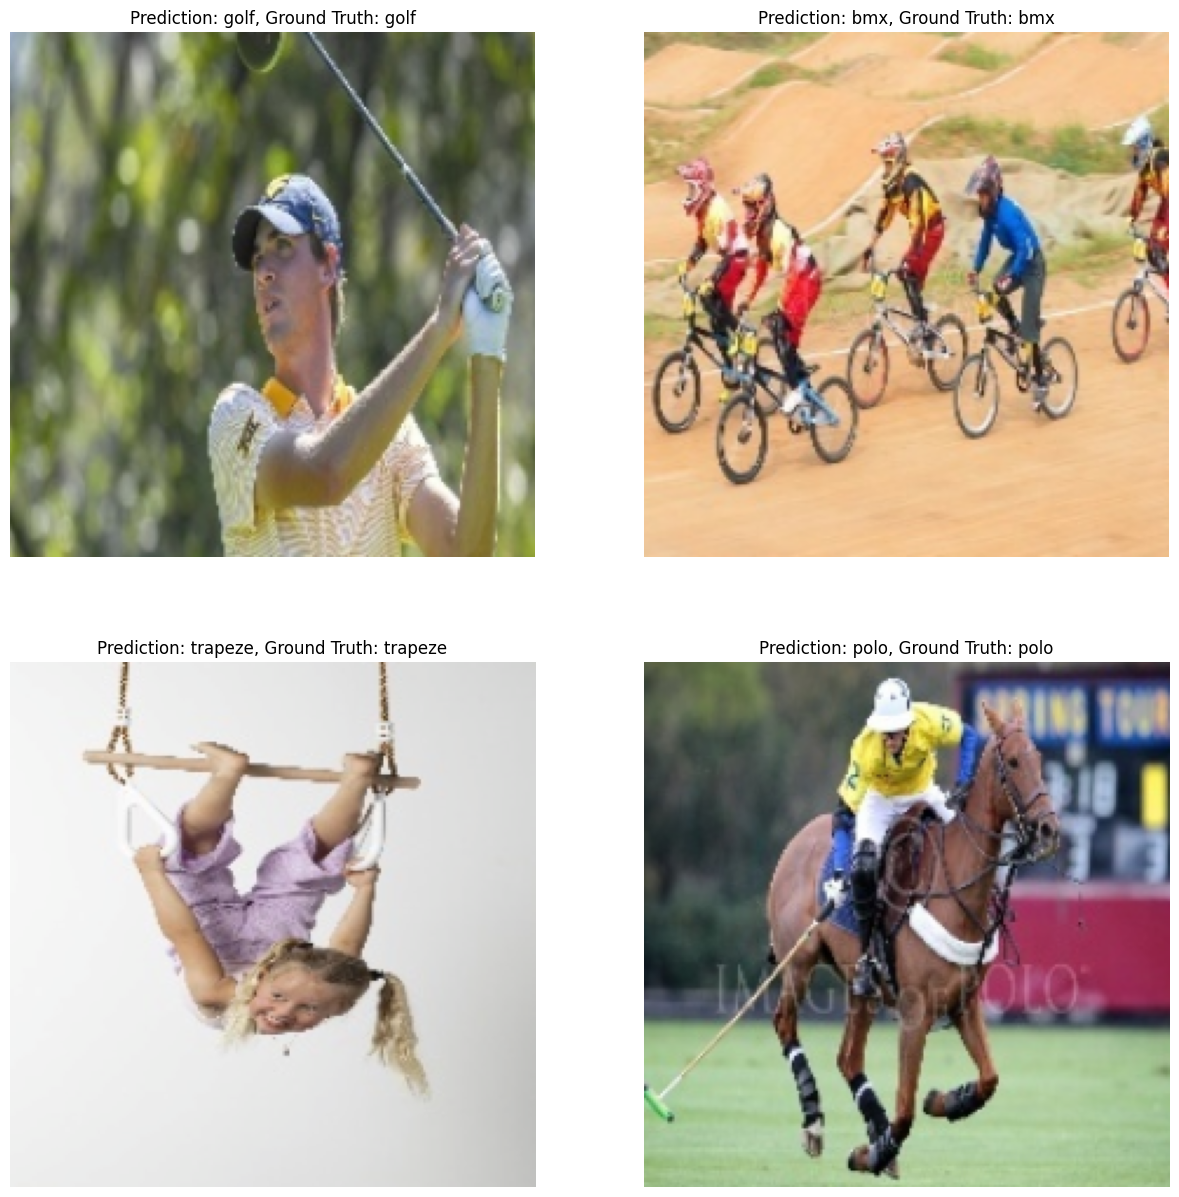

In [30]:
visualize_predicitions(model_finetune, 4)